# Simulation experiment for detection thresholds for variant calling

This notebook is to get detection thresholds for the limit of the variant calling based on: 

1. Read depth
2. Error rate
3. Number of mutations


Also optionaly get the time it takes to complete experiments per sequence length.


```
>lcl|NC_000913.3_cds_NP_414902.1_362 [gene=tauD] [locus_tag=b0368] [db_xref=UniProtKB/Swiss-Prot:P37610] [protein=taurine dioxygenase] [protein_id=NP_414902.1] [location=387795..388646] [gbkey=CDS]
```

From: ecoli_GCF_000005845.2_ASM584v2_cds_from_genomic.fna
and >NP_414902.1 taurine dioxygenase [Escherichia coli str. K-12 substr. MG1655]



In [5]:
import pandas as pd
# Visualisation things to make the figures look nice
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sciutil import SciUtil


data_dir = 'ePCR_data/'
fig_dir = 'ePCR_figures/'


plt.rcParams['svg.fonttype'] = 'none'
axis_line_width = 1.0
axis_font_size = 12
title_font_size = 12
label_font_size = 10
figsize = (5, 4) # Figure size
font = 'Arial'
style = 'ticks'
font_family = 'sans-serif'

# Create a figure with 2x2 subplots
sns.set_style("whitegrid")
cmap = 'viridis'
palette = sns.color_palette("viridis", as_cmap=True)
sns.set_palette(cmap)

sns.set(rc={'figure.figsize': figsize, 'font.family': font_family,
            'font.sans-serif': font, 'font.size': label_font_size}, style=style)

def set_ax_params(ax):
    ax.tick_params(direction='out', length=2, width=axis_line_width)
    ax.spines['bottom'].set_linewidth(axis_line_width)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(axis_line_width)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=axis_font_size)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.tick_params(labelsize=label_font_size)


u = SciUtil()

# Generate mutations on a "real" sequence
# Decided to choose tauD from Ecoli K12
parent_sequence_aa = 'MSERLSITPLGPYIGAQISGADLTRPLSDNQFEQLYHAVLRHQVVFLRDQAITPQQQRALAQRFGELHIHPVYPHAEGVD\
EIIVLDTHNDNPPDNDNWHTDVTFIETPPAGAILAAKELPSTGGDTLWTSGIAAYEALSVPFRQLLSGLRAEHDFRKSFP\
EYKYRKTEEEHQRWREAVAKNPPLLHPVVRTHPVSGKQALFVNEGFTTRIVDVSEKESEALLSFLFAHITKPEFQVRWRW\
QPNDIAIWDNRVTQHYANADYLPQRRIMHRATILGDKPFYRAG'

parent_sequence = 'ATGAGTGAACGTCTGAGCATTACCCCGCTGGGGCCGTATATCGGCGCACAAATTTCGGGTGCCGACCTGACGCGCCCGTT\
AAGCGATAATCAGTTTGAACAGCTTTACCATGCGGTGCTGCGCCATCAGGTGGTGTTTCTACGCGATCAAGCTATTACGC\
CGCAGCAGCAACGCGCGCTGGCCCAGCGTTTTGGCGAATTGCATATTCACCCTGTTTACCCGCATGCCGAAGGGGTTGAC\
GAGATCATCGTGCTGGATACCCATAACGATAATCCGCCAGATAACGACAACTGGCATACCGATGTGACATTTATTGAAAC\
GCCACCCGCAGGGGCGATTCTGGCAGCTAAAGAGTTACCTTCGACCGGCGGTGATACGCTCTGGACCAGCGGTATTGCGG\
CCTATGAGGCGCTCTCTGTTCCCTTCCGCCAGCTGCTGAGTGGGCTGCGTGCGGAGCATGATTTCCGTAAATCGTTCCCG\
GAATACAAATACCGCAAAACCGAGGAGGAACATCAACGCTGGCGCGAGGCGGTCGCGAAAAACCCGCCGTTGCTACATCC\
GGTGGTGCGAACGCATCCGGTGAGCGGTAAACAGGCGCTGTTTGTGAATGAAGGCTTTACTACGCGAATTGTTGATGTGA\
GCGAGAAAGAGAGCGAAGCCTTGTTAAGTTTTTTGTTTGCCCATATCACCAAACCGGAGTTTCAGGTGCGCTGGCGCTGG\
CAACCAAATGATATTGCGATTTGGGATAACCGCGTGACCCAGCACTATGCCAATGCCGATTACCTGCCACAGCGACGGAT\
AATGCATCGGGCGACGATCCTTGGGGATAAACCGTTTTATCGGGCGGGGTAA'

# Introduce mutations at a given frequency and an error rate

Test setup:

Change to 0.1 - 5% 0.2% step size. 

1. For number of mutations from 1 to the sequence length test mutating each one and correlate this to the p value
2. For sequencing error rates from 0 to 100% make sequences ranging with this and see what the results are for the p value and the error
3. For different sequence lengths also check how sequence length corresponds to the pvalue

In [6]:
from minION import *
from tqdm import tqdm

def make_experiment(run_label, read_depth, sequencing_error_rate, parent_sequence, positions, library_number, 
                    number_of_wells, epcr_mutation_rate, frequency_cutoff=0.5):
    # Make a full experiment setup
    mutated_sequence = make_epcr_de_experiment(read_depth, sequencing_error_rate, parent_sequence, library_number,
                                                   epcr_mutation_rate)
    
    variant_df = get_dummy_plate_df(run_label, 'Well', number_of_wells)  # i.e. 20 - 1 since we don't have the other variant    
    mutant_to_well_df = {}
    current_well = 0
    for mutant in tqdm(mutated_sequence):
        parent_name = 'Parent'
        reads = []
        read_ids = []
        quals = []
        for i, seq in enumerate(mutated_sequence[mutant]):
            read_ids.append(f'read_{i}')
            reads.append(seq)
            quals.append(100)  # Dummy don't need
    
        well_df = make_well_df_from_reads(reads, read_ids, quals)
        rows_all = make_row_from_read_pileup_across_well(well_df, parent_sequence, parent_name)
        well_df = pd.DataFrame(rows_all)
        well_df.columns = ['gene_name', 'position', 'ref', 'most_frequent', 'freq_non_ref', 'total_other',
                           'total_reads', 'p_value', 'percent_most_freq_mutation', 'A', 'p(a)', 'T', 'p(t)', 'G',
                           'p(g)',
                           'C', 'p(c)', 'N', 'p(n)']
        well_df = calculate_mutation_significance_across_well(well_df)
        label, frequency, combined_p_value, mixed_well = get_variant_label_for_well(well_df, frequency_cutoff)
        # This should be mutated at 100% - the rate of our sequencing errror
        if verbose:
            u.dp(["label", label, f"frequency", frequency, f"combined_p_value", combined_p_value, "mixed_well", mixed_well])
        mutant_to_well_df[f'{mutant}_{current_well}'] = well_df
        variant_df.at[current_well, "Mixed Well"] = mixed_well
        variant_df.at[current_well, "Variant"] = label
        variant_df.at[current_well, "frequency"] = frequency
        variant_df.at[current_well, "P value"] = combined_p_value
        variant_df.at[current_well, "Well"] = f'Well {current_well}'
        variant_df.at[current_well, "Alignment_count"] = read_depth
        current_well += 1

    # Before returning adjust the pvalues
    variant_df['P adj.'] = multipletests(list(variant_df["P value"].values), alpha=0.05, method='fdr_bh')[1]
    return variant_df

## Experiment 1: Varying the sequencing error rate for a single mutation

In [19]:
# We're going to make an experiment of 10 plates with different sequencing error rates
read_depth = 100
number_of_wells = 19
epcr_mutation_rate = 0.02
frequency_cutoff=0.5
library_number = 96 # Usually do a 96 well plate
verbose = False
for position in [1, 20, 100]:
    experiment_df = pd.DataFrame()
    positions = [position]
    for sequencing_error in range(0, 100, 5):
        sequencing_error_rate = sequencing_error/100.0
        run_df = make_experiment(f'SeqError_{sequencing_error}', read_depth, sequencing_error_rate, parent_sequence, positions, 
                                 library_number, number_of_wells, epcr_mutation_rate, frequency_cutoff)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])

    # Also plot each one
    experiment_df.to_csv(f'{data_dir}Experiment1_position:{position}.csv', index=False)
    # experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    # experiment_df['Error rate'] = [int(c.split('_')[-1])/100.0 for c in experiment_df['Plate']]
    # experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    # experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    # experiment_df = experiment_df.reset_index()
    # ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Error rate', palette='viridis', 
    #                      style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    # set_ax_params(ax)
    # plt.xlabel('Mutation frequency')
    # plt.ylabel('-log10(padj)')
    # plt.title('Effect of sequencing error on significance', fontsize=title_font_size, fontweight="bold")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # plt.savefig(f'{fig_dir}Experiment1_position:{position}.svg')
    # plt.show()

100%|█| 96/96 [00:40<00:00,  2.37it/
  0%|        | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9720000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.80it/
  0%|        | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9026086956521739' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:57<00:00,  1.66it/
  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl

## Experiment 2: Varying the sequencing error rate for a multiple mutations

In [20]:
verbose = False
for positions in [[50, 14, 90]]:
    experiment_df = pd.DataFrame()
    positions = positions
    number_of_wells = (19*3)  # 19 aas * 3 positions
    for sequencing_error in range(0, 100, 10):
        sequencing_error_rate = sequencing_error/100.0
        run_df = make_experiment(f'SeqError_{sequencing_error}', read_depth, sequencing_error_rate, parent_sequence, positions, 
                                 library_number, number_of_wells, epcr_mutation_rate, frequency_cutoff)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])

    # Also plot each one
    positions = [str(s) for s in positions]
    experiment_df.to_csv(f'{data_dir}Experiment2_position:{"-".join(positions)}.csv', index=False)
    # experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    # experiment_df['Error rate'] = [int(c.split('_')[-1])/100.0 for c in experiment_df['Plate']]
    # experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    # experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    # experiment_df = experiment_df.reset_index()
    # ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Error rate', palette='viridis', 
    #                      style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    # set_ax_params(ax)
    # plt.xlabel('Mutation frequency')
    # plt.ylabel('-log10(padj)')
    # plt.title('Effect of sequencing error on significance', fontsize=title_font_size, fontweight="bold")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # plt.savefig(f'{fig_dir}Experiment2_positions:{"-".join(positions)}.svg')
    # plt.show()

100%|█| 96/96 [00:37<00:00,  2.54i
  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9094444444444445' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.80i
  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7947058823529412' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:54<00:00,  1.75i
  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000g

## Experiment 3: varying read depth and it's effect on significance (1 position)

90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7727272727272727' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:38<00:00,  2.49i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.90625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:40<00:00,  2.36i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8592592592592594' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:42<00:00,  2.27i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9205882352941176' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:43<00:00,  2.18i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8999999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:44<00:00,  2.14i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.89375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:46<00:00,  2.08i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8857142857142857' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:47<00:00,  2.04i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8819444444444443' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:48<00:00,  1.99i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.896969696969697' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:48<00:00,  1.97i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.892' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:49<00:00,  1.94i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.926060606060606' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:50<00:00,  1.91i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8939393939393938' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:50<00:00,  1.88i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8860139860139861' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:51<00:00,  1.88i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8874999999999998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:56<00:00,  1.69i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8918518518518519' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.81i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8986111111111111' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:52<00:00,  1.81i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9019607843137257' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:52<00:00,  1.82i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.895679012345679' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.80i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9039473684210527' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.80i
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/743830292.py:17: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/1209066250.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


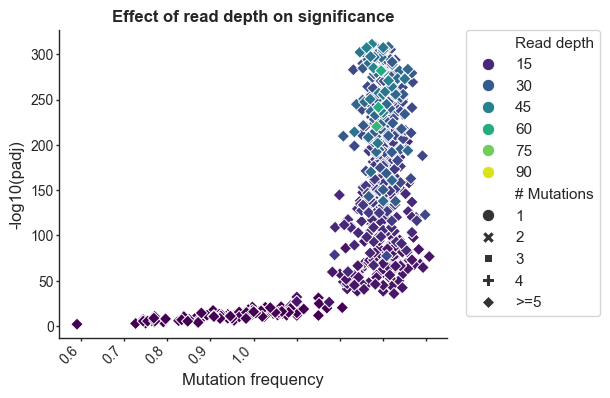

90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7368421052631579' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:39<00:00,  2.45i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8588235294117647' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:47<00:00,  2.04i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9066666666666668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:42<00:00,  2.25i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9035714285714286' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:43<00:00,  2.20i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8640000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:44<00:00,  2.14i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8925925925925926' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:46<00:00,  2.08i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9203007518796994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:47<00:00,  2.03i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8788461538461539' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:47<00:00,  2.00i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9000000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:49<00:00,  1.96i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9011111111111111' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:49<00:00,  1.94i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8945454545454545' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:50<00:00,  1.91i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9019230769230769' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:50<00:00,  1.90i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8987854251012145' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:51<00:00,  1.87i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9026785714285714' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:51<00:00,  1.86i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9058333333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:52<00:00,  1.84i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9013888888888888' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:52<00:00,  1.82i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8745098039215686' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:52<00:00,  1.82i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9077777777777778' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.81i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9052631578947368' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.80i
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/743830292.py:17: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/1209066250.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


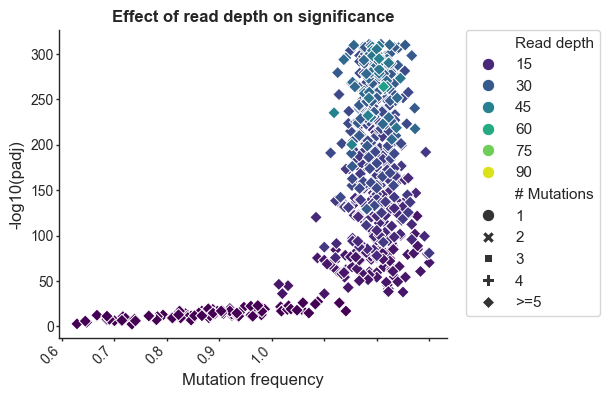

90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.73' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:38<00:00,  2.47i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.93' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:40<00:00,  2.36i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8941176470588236' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:42<00:00,  2.27i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9033333333333332' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:43<00:00,  2.19i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8886956521739132' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:44<00:00,  2.14i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8753623188405797' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:46<00:00,  2.08i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9090909090909091' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:47<00:00,  2.03i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8819444444444443' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:49<00:00,  1.95i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9152777777777779' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:50<00:00,  1.88i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9146666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:51<00:00,  1.88i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9012987012987012' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:51<00:00,  1.86i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9071428571428571' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:51<00:00,  1.85i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.894017094017094' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.81i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8972350230414746' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.81i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9016666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.79i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8941176470588234' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:53<00:00,  1.78i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8991596638655464' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:54<00:00,  1.77i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8962962962962965' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:54<00:00,  1.76i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8972136222910216' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:54<00:00,  1.75i
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/743830292.py:17: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/1209066250.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


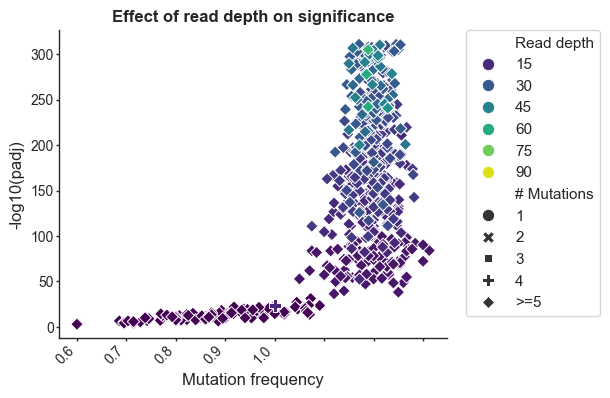

In [21]:
# We're going to make an experiment of 10 plates with different sequencing error rates
sequencing_error_rate = 0.1
number_of_wells = 96

for position in [1, 20, 100]:
    positions = [position]
    experiment_df = pd.DataFrame()
    for read_depth in range(5, 100, 5):
        print(sequencing_error)
        run_df = make_experiment(f'ReadDepth_{read_depth}', read_depth, sequencing_error_rate, parent_sequence, positions, 
                         library_number, number_of_wells, epcr_mutation_rate, frequency_cutoff)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])
    
     # Also plot each one
    experiment_df.to_csv(f'{data_dir}Experiment3_position:{position}.csv', index=False)
    experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    experiment_df['Read depth'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
    experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    experiment_df = experiment_df.reset_index()
    ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Read depth', palette='viridis', 
                         style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    set_ax_params(ax)
    plt.xlabel('Mutation frequency')
    plt.ylabel('-log10(padj)')
    plt.title('Effect of read depth on significance', fontsize=title_font_size, fontweight="bold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f'{fig_dir}Experiment3_position:{position}.svg')
    plt.show()

## Experiment 4: effect of sequence length on significance


90


  0%|      | 0/19 [00:00<?, ?it/s]/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 19/19 [00:00<00:00, 68.31i


90


  0%|      | 0/67 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 67/67 [00:03<00:00, 19.44i


90


  0%|      | 0/88 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8999999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
 16%|▏| 14/88 [00:01<00:06, 12.18i/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 88/88 [00:07<00:00, 11.94i


90


  0%|      | 0/95 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8959999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
 63%|▋| 60/95 [00:07<00:04,  8.26i/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 95/95 [00:11<00:00,  8.36i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9199999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
 26%|▎| 25/96 [00:03<00:10,  6.77i/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 96/96 [00:14<00:00,  6.61i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.92' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:17<00:00,  5.42i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8700000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:20<00:00,  4.63i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.908' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:23<00:00,  4.02i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9199999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:27<00:00,  3.55i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.911111111111111' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:30<00:00,  3.14i
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/1209066250.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


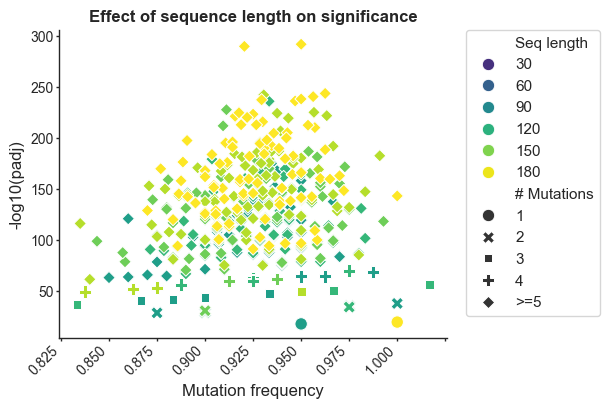

90


  0%|      | 0/25 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.84' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 25/25 [00:00<00:00, 67.77i


90


  0%|      | 0/78 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.94' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
  3%| | 2/78 [00:00<00:03, 19.62it/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 78/78 [00:03<00:00, 20.62i


90


  0%|      | 0/92 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.92' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
 28%|▎| 26/92 [00:02<00:05, 12.07i/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 92/92 [00:07<00:00, 12.09i


90


  0%|      | 0/94 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.92' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
  3%| | 3/94 [00:00<00:10,  8.41it/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 94/94 [00:11<00:00,  8.43i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9039999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
 19%|▏| 18/96 [00:02<00:11,  6.69i/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 96/96 [00:14<00:00,  6.60i


90


  1%| | 1/96 [00:00<00:17,  5.36it/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.885' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:17<00:00,  5.48i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.911111111111111' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:20<00:00,  4.61i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9199999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:24<00:00,  4.00i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.924' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:27<00:00,  3.55i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9022222222222224' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:30<00:00,  3.16i
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/1209066250.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


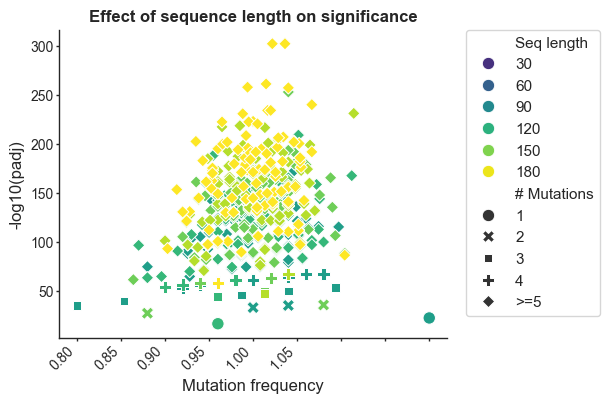

90


  0%|      | 0/17 [00:00<?, ?it/s]/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 17/17 [00:00<00:00, 67.62i


90


  0%|      | 0/81 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.88' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
 11%| | 9/81 [00:00<00:03, 19.45it/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 81/81 [00:04<00:00, 19.77i


90


  0%|      | 0/90 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.89' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
  4%| | 4/90 [00:00<00:07, 11.86it/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ariane/opt/miniconda3/envs/minion/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█| 90/90 [00:07<00:00, 12.11i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.88' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:11<00:00,  8.36i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9066666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:14<00:00,  6.69i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8733333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:17<00:00,  5.43i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9199999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:20<00:00,  4.59i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:24<00:00,  3.99i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8933333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:27<00:00,  3.56i


90


  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9022222222222224' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:30<00:00,  3.16i
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/1209066250.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


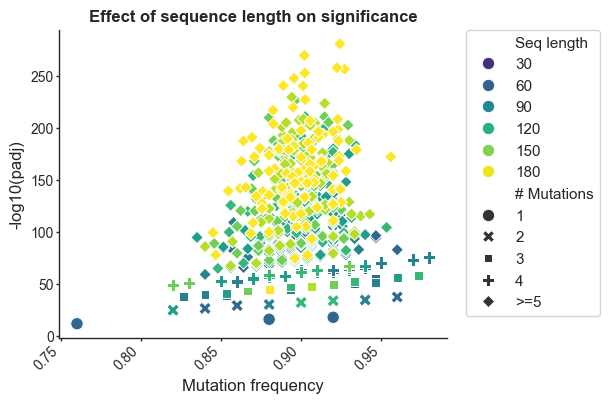

In [22]:
# We're going to make an experiment of 10 plates with different sequencing error rates
sequencing_error_rate = 0.1
number_of_wells = 96
read_depth = 25

for position in [1, 2, 3]:
    positions = [position]
    experiment_df = pd.DataFrame()
    for seq_len in range(5, 200, 20):
        print(sequencing_error)
        run_df = make_experiment(f'SeqLen_{seq_len}', read_depth, sequencing_error_rate, parent_sequence[:seq_len*3], positions, 
                 library_number, number_of_wells, epcr_mutation_rate, frequency_cutoff)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])
    
     # Also plot each one
    experiment_df.to_csv(f'{data_dir}Experiment4_position:{position}.csv', index=False)
    experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    experiment_df['Seq length'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
    experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    experiment_df = experiment_df.reset_index()
    ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Seq length', palette='viridis', 
                         style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    set_ax_params(ax)
    plt.xlabel('Mutation frequency')
    plt.ylabel('-log10(padj)')
    plt.title('Effect of sequence length on significance', fontsize=title_font_size, fontweight="bold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f'{fig_dir}Experiment4_position:{position}.svg')
    plt.show()

In [18]:
experiment_df

,index,Plate,Well,Path,Alignment_count,P value,Mixed Well,Variant,mutation,frequency,P adj.,value,-log10(P.adj)
0,0,ReadDepth_5,Well 0,,5.0,6.134913e-07,False,T6A_C25A_G72T_A150DEL_A164C_G222T_C278A_A284G_...,,0.582609,6.692632e-07,0.0,6.174403
1,1,ReadDepth_5,Well 1,,5.0,1.908562e-15,False,G112A_T153A_A230G_G238C_G250T_T258A_T314A_C369...,,0.820000,4.021783e-15,0.0,14.395581
2,2,ReadDepth_5,Well 2,,5.0,1.284823e-16,False,T37G_G43A_G194A_T207A_C228A_G233T_A266C_C285A_...,,0.739130,3.426194e-16,0.0,15.465188
3,3,ReadDepth_5,Well 3,,5.0,4.360662e-08,False,T53A_C172T_G193T_A197T_A198T_C246A_A350T_T360A...,,0.700000,4.867716e-08,0.0,7.312675
4,4,ReadDepth_5,Well 4,,5.0,1.395608e-24,False,T2A_A22G_T37G_C109G_G129T_C172G_T225A_A263T_C2...,,0.826087,1.913977e-23,0.0,22.718063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,NaN,Well 91,NaN,95.0,0.000000e+00,False,C35G_C63A_T104A_T215A_C275G_T361C_G449A_A482T_...,NaN,0.906220,0.000000e+00,NaN,inf
92,92,NaN,Well 92,NaN,95.0,0.000000e+00,False,G7A_G143C_A287G_T314G_G321A_T419G_C495T_G526C_...,NaN,0.894737,0.000000e+00,NaN,inf
93,93,NaN,Well 93,NaN,95.0,0.000000e+00,False,A4G_C71T_G74A_G133T_G222A_T258A_C261G_C358G_C4...,NaN,0.891930,0.000000e+00,NaN,inf
94,94,NaN,Well 94,NaN,95.0,0.000000e+00,False,C25T_G59A_C73T_A107C_C144T_G151A_T199C_C240T_A...,NaN,0.903947,0.000000e+00,NaN,inf


In [23]:
# We're going to make an experiment of 10 plates with different sequencing error rates
sequencing_error_rate = 0.1
read_depth = 25

for position in [1, 20, 100]:
    positions = [position]
    experiment_df = pd.DataFrame()
    for frequency_cutoff in range(10, 90, 10):
        run_df = make_experiment(f'FreqCutoff_{frequency_cutoff}', read_depth, sequencing_error_rate, parent_sequence, positions, library_number, number_of_wells, epcr_mutation_rate, frequency_cutoff/100.0)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])
    
     # Also plot each one
    experiment_df.to_csv(f'{data_dir}Experiment5_position:{position}.csv', index=False)
    # experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
    # experiment_df['Seq length'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
    # experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
    # experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
    # experiment_df = experiment_df.reset_index()
    # ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Seq length', palette='viridis', 
    #                      style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
    # set_ax_params(ax)
    # plt.xlabel('Mutation frequency')
    # plt.ylabel('-log10(padj)')
    # plt.title('Effect of frequency cutoff on significance', fontsize=title_font_size, fontweight="bold")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # plt.savefig(f'{fig_dir}Experiment5_position:{position}.svg')
    # plt.show()

  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.12183673469387757' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:46<00:00,  2.08i
  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5023255813953488' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:46<00:00,  2.06i
  0%|      | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:

In [30]:
# We're going to make an experiment of 10 plates with different sequencing error rates
sequencing_error_rate = 0.1
read_depth = 25
frequency_cutoff = 0.5 

for position in [1, 20, 100]:
    positions = [position]
    experiment_df = pd.DataFrame()
    for epcr_mutation_rate in range(1, 10, 1):
        run_df = make_experiment(f'ePCR_{epcr_mutation_rate}', read_depth, sequencing_error_rate, parent_sequence, positions, library_number, number_of_wells, 
                                 epcr_mutation_rate/100.0, frequency_cutoff)
        run_df.reset_index(inplace=True)
        experiment_df = pd.concat([experiment_df, run_df])
    
     # Also plot each one
    experiment_df.to_csv(f'{data_dir}Experiment6_position:{position}.csv', index=False)


  0%|        | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8577777777777779' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:46<00:00,  2.06it/
  0%|        | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/2604269417.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9011764705882354' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  variant_df.at[current_well, "frequency"] = frequency
100%|█| 96/96 [00:47<00:00,  2.02it/
  0%|        | 0/96 [00:00<?, ?it/s]/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/26042

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/290590502.py:1: RuntimeWarning: divide by zero encountered in log10
  experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_28643/1209066250.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


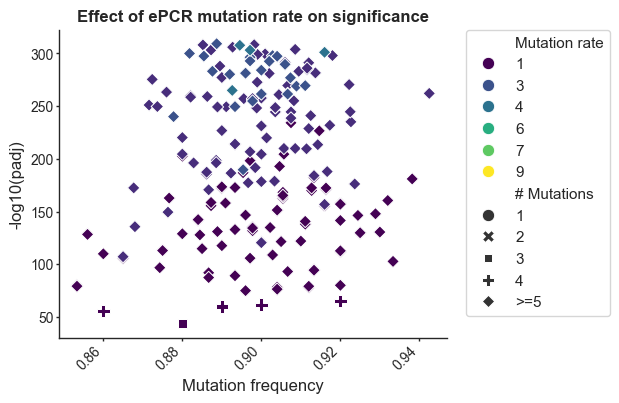

In [33]:
experiment_df['-log10(P.adj)'] = -1*np.log10(experiment_df['P adj.'].values)
experiment_df['Mutation rate'] = [int(c.split('_')[-1]) for c in experiment_df['Plate']]
experiment_df['# Mutations'] = [len(v.split('_')) for v in experiment_df['Variant'].values]
experiment_df['# Mutations'] = [f'{v}' if v < 5 else f'>=5' for v in experiment_df['# Mutations']]
experiment_df = experiment_df.reset_index()
experiment_df.replace(
ax = sns.scatterplot(experiment_df, x='frequency', y='-log10(P.adj)', hue='Mutation rate', palette='viridis', 
                     style="# Mutations", style_order=['1', '2', '3', '4', '>=5'], s=80)
set_ax_params(ax)
plt.xlabel('Mutation frequency')
plt.ylabel('-log10(padj)')
plt.title('Effect of ePCR mutation rate on significance', fontsize=title_font_size, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{fig_dir}Experiment5_position:{position}.svg')
plt.show()

In [32]:
experiment_df

,index,Plate,Well,Path,Alignment_count,P value,Mixed Well,Variant,mutation,frequency,P adj.,value,-log10(P.adj),Mutation rate,# Mutations
0,0,ePCR_1,Well 0,,25,7.067343e-77,False,C139G_A170G_A455C_T616G_T768G,,0.904000,7.798448e-77,0,76.107992,1,>=5
1,1,ePCR_1,Well 1,,25,1.088597e-92,False,G36T_C100A_C240A_T339G_G346C_C402T,,0.886667,1.357211e-92,0,91.867352,1,>=5
2,2,ePCR_1,Well 2,,25,2.179512e-171,False,A1G_A70G_C178T_G180T_T206G_T236G_G384T_G408A_A...,,0.912727,1.230783e-170,0,169.909818,1,>=5
3,3,ePCR_1,Well 3,,25,9.492683e-157,False,G72A_C163G_G238C_C253G_T270C_G304C_C366G_A470G...,,0.916000,2.939670e-156,0,155.531701,1,>=5
4,4,ePCR_1,Well 4,,25,2.298845e-95,False,G46T_C124T_G130A_C174G_G343C_A650C,,0.913333,2.982285e-95,0,94.525451,1,>=5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,ePCR_9,Well 91,,25,0.000000e+00,False,G32C_G44T_C63G_G83T_T96G_A128G_G135T_A149G_C17...,,0.898857,0.000000e+00,0,inf,9,>=5
92,92,ePCR_9,Well 92,,25,0.000000e+00,False,A4T_G7C_A9C_G15C_G32C_C56T_T79C_C84T_T131A_T13...,,0.903099,0.000000e+00,0,inf,9,>=5
93,93,ePCR_9,Well 93,,25,0.000000e+00,False,A8T_T21C_G36C_T55G_G57C_T68G_C71G_T80C_A81C_C1...,,0.896709,0.000000e+00,0,inf,9,>=5
94,94,ePCR_9,Well 94,,25,0.000000e+00,False,G5A_T14G_G30T_G31T_C42T_T53A_C73G_G97T_T106A_A...,,0.902609,0.000000e+00,0,inf,9,>=5
